In [4]:
import numpy as np
import math
import matplotlib.pyplot as plt
import sklearn.manifold as skm

import numpy as np
import matplotlib.pyplot as plt
##Notes
# Implemented PCA and early exaggeration which are both outlined in the original paper
# Subsampled the original dataset since it was crashing my computer
#Plot attached was created with 5000 as max iteration with 2000 images

In [5]:




def compute_pairwise_distances(X):
    sum_X = np.sum(np.square(X), 1)
    D = np.add(np.add(-2 * np.dot(X, X.T), sum_X).T, sum_X)
    return D

def Hbeta(Di, beta):
    P = np.exp(-Di * beta)

    sumP = np.sum(P)
    #Set a zero value as very low to avoid dividing by 0
    if sumP == 0:
        sumP = 1e-10 
    H = np.log(sumP) + beta * np.sum(Di * P) / sumP
    P = P / sumP
    return H, P

def binary_search_perplexity(Di, target_perplexity, tol=1e-5, max_iter=50):
    beta_min = -np.inf
    beta_max = np.inf
    beta = 1.0
    H, P = Hbeta(Di, beta)
    H_diff = H - np.log(target_perplexity)
    iter = 0
    while np.abs(H_diff) > tol and iter < max_iter:
        if H_diff > 0:
            beta_min = beta
            beta = beta * 2.0 if beta_max == np.inf else (beta + beta_max) / 2.0
        else:
            beta_max = beta
            beta = beta / 2.0 if beta_min == -np.inf else (beta + beta_min) / 2.0
        H, P = Hbeta(Di, beta)
        H_diff = H - np.log(target_perplexity)
        iter += 1
    return P

def compute_P(X, perplexity=30.0):
    (n, d) = X.shape
    D = compute_pairwise_distances(X)
    P = np.zeros((n, n))
    for i in range(n):
        # Exclude the self-distance
        Di = np.delete(D[i], i)
        P_i = binary_search_perplexity(Di, perplexity)
        P[i, np.concatenate((np.r_[0:i], np.r_[i+1:n]))] = P_i
    # Symmetrize P and normalize
    P = (P + P.T) / (2 * n)
    return P

def pca(X, no_dims=50):
    X = X - np.mean(X, axis=0)
    cov_X = np.cov(X, rowvar=False)
    eig_vals, eig_vecs = np.linalg.eigh(cov_X)
    idx = np.argsort(eig_vals)[::-1]
    eig_vecs = eig_vecs[:, idx]
    eig_vals = eig_vals[idx]
    Y = np.dot(X, eig_vecs[:, :no_dims])
    return Y

def tsne(X, no_dims=2, initial_dims=50, perplexity=30.0, max_iter=1000):
    # Check if initial dimensionality reduction is needed
    (n, d) = X.shape
    if d > initial_dims:
        print("Preprocessing the data using PCA...")
        X = pca(X, initial_dims)
    else:
        X = X - np.mean(X, axis=0)

    # Compute pairwise affinities P
    print("Computing pairwise distances...")
    P = compute_P(X, perplexity)
    P = np.maximum(P, 1e-12)

    # Initialize the solution Y randomly
    Y = np.random.randn(n, no_dims)
    dY = np.zeros((n, no_dims))
    iY = np.zeros((n, no_dims))
    gains = np.ones((n, no_dims))


    P = P * 4.0

    # Set hyperparameters
    momentum = 0.5
    eta = 200.0

    for iter in range(max_iter):
       
        sum_Y = np.sum(np.square(Y), axis=1)
        num = -2.0 * np.dot(Y, Y.T)
        num = 1.0 / (1.0 + np.add(np.add(num, sum_Y).T, sum_Y))
        num[range(n), range(n)] = 0.0 
        Q = num / np.sum(num)
        Q = np.maximum(Q, 1e-12)
        # Compute gradient
        PQ = P - Q
        for i in range(n):
            dY[i, :] = np.sum(np.tile(PQ[:, i] * num[:, i], (no_dims, 1)).T * (Y[i, :] - Y), axis=0)
        # Update gains
        gains = (gains + 0.2) * ((dY > 0.0) != (iY > 0.0)) + (gains * 0.8) * ((dY > 0.0) == (iY > 0.0))
        gains[gains < 0.01] = 0.01
        # Update the solution
        iY = momentum * iY - eta * (gains * dY)
        Y = Y + iY
        Y = Y - np.mean(Y, axis=0)
        if iter == 100:
            P = P / 4.0
        if iter == 20:
            momentum = 0.8
        # Print progress
        if (iter + 1) % 100 == 0:
            C = np.sum(P * np.log(P / Q))
            print(f"Iteration {iter + 1}: error is {C}")

    return Y



    

(70000, 784)
(2000, 784)
Preprocessing the data using PCA...
Computing pairwise distances...
Iteration 100: error is 16.396778312433753
Iteration 200: error is 1.3485629631985132
Iteration 300: error is 1.1776731312169602
Iteration 400: error is 1.1130800643389718
Iteration 500: error is 1.0810287459844785
Iteration 600: error is 1.061972261420834
Iteration 700: error is 1.050255769208279
Iteration 800: error is 1.042777627214706
Iteration 900: error is 1.0372312518187894
Iteration 1000: error is 1.033394935871932


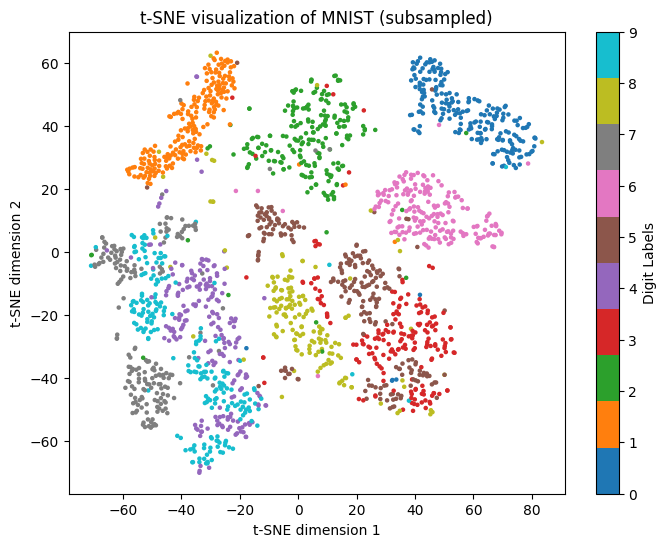

In [6]:
from sklearn.datasets import fetch_openml
data = fetch_openml('mnist_784', version=1)
    
X = data.data
labels = data.target
print(X.shape)
n_samples = 2000  #subsample to save memory
idx = np.random.choice(X.shape[0], n_samples, replace=False)
X_subsample = X.iloc[idx].values
labels_subsample = labels.iloc[idx].values 
print(X_subsample.shape)
    # Run t-SNE
Y = tsne(X_subsample, no_dims=2, initial_dims=50, perplexity=30.0, max_iter=5000)
    
    
    #Validation by using prebuilt library
    #X_embedded = skm.TSNE(n_components=2, learning_rate='auto',
    #              init='random', perplexity=30.0).fit_transform(X_subsample)
    # Plot the results
labels_subsample = labels_subsample.astype(int)
# Scatter plot for the custom t-SNE implementation
plt.figure(figsize=(8, 6))
scatter = plt.scatter(Y[:, 0], Y[:, 1], c=labels_subsample, cmap='tab10', s=5)
plt.colorbar(scatter, ticks=range(10), label='Digit Labels')
plt.title("t-SNE visualization of MNIST (subsampled)")
plt.xlabel("t-SNE dimension 1")
plt.ylabel("t-SNE dimension 2")
plt.show()

# Scatter plot for the built-in t-SNE
    #plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=labels_subsample, cmap='viridis', s=5)
    #plt.colorbar()
    #plt.title("t-SNE visualization of the MNIST dataset (built-in)")
    #plt.show()